In [56]:
import pandas as pd
import numpy as np
import scipy as sp
import sympy as smp
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv("coil_position_data.txt")
df.columns=['w_t','LV']
df.head()

,w_t,LV
0,0.000001,3.000000
1,2.170418,3.023155
2,3.183280,3.037627
3,4.340836,3.049204
4,6.221865,3.057887


In [58]:
w_t = smp.symbols('w_t', positive=True) # 
LV_spline = smp.interpolating_spline( 3 , w_t , df['w_t'] , df['LV'])

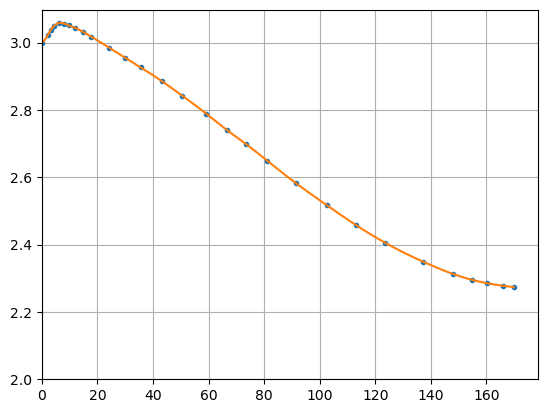

In [59]:
plt.plot(df['w_t'],df['LV'],'.')

w_t_step = 0.1 #mm
w_t_vector = np.arange(0,max(df['w_t']),w_t_step)
LV_vector = smp.lambdify(w_t, LV_spline, "numpy")(w_t_vector)
plt.plot(w_t_vector,LV_vector)

plt.grid()
plt.ylim(bottom=2)
plt.xlim(left=0)
plt.show()

In [66]:
LV_func = lambda wheel_travel: LV_spline.subs( w_t , wheel_travel)

inv_LV = smp.lambdify(w_t, 1/LV_spline, "numpy") 

from scipy.integrate import quad
s_s_func = lambda wheel_travel: quad( inv_LV , 0 , wheel_travel )[0]

In [72]:
chainstay=440
wheel_base=1200
rear_split= 1 - chainstay/wheel_base

mass = 80

k_spring = 70050.734 # N/m = 400 lbs/in

k_bumper = mass*0.01/10e-3  # N/m  G=0.01
bumper_height = 15 # milimeter

shock_max_stroke = round( s_s_func( max(df['w_t'])) , 0) 

damper_stiffness = 4500/2.5 # N / m/s     4500N ~ 1000lbf


In [73]:
F_spring_func = lambda wheel_travel: k_spring * s_s_func(wheel_travel)/1000
    #n Newtons


F_w_spring_func = lambda wheel_travel: F_spring_func(wheel_travel) / LV_func(wheel_travel)
    # Newtons


F_bumper_func = lambda wheel_travel: k_bumper*(shock_max_stroke-s_s_func(wheel_travel))/1000 if (s_s_func(wheel_travel) > shock_max_stroke - bumper_height) else 0
    # Newtons

F_w_bumper_func = lambda wheel_travel: F_bumper_func(wheel_travel) / LV_func(wheel_travel)
    # Newtons


F_damper_func = lambda wheel_travel , wheel_velocity: damper_stiffness * wheel_velocity / LV_func(wheel_travel)
    # Travel = milimeter , Velocity = meter/s
    #shock_velocity = wheel_velocity / LV_func(wheel_travel)
    
F_w_damper_func = lambda wheel_travel , wheel_velocity: F_damper_func( wheel_travel , wheel_velocity) / LV_func(wheel_travel)
    # Newtons


In [75]:
# Wheel Spring Force at bottom out
F_w_spring_func(w_t_vector)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()